In [23]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px

In [15]:
df = pd.read_excel('OnlineRetail.xlsx')

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [18]:
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]

In [33]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [34]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [35]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [36]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
summary = summary_data_from_transaction_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end=snapshot_date
)
summary = summary[(summary['monetary_value'] > 0) & (summary['frequency'] > 0)]

summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,368.0,599.701667
12348.0,3.0,283.0,359.0,301.480000
12352.0,6.0,260.0,297.0,368.256667
12356.0,2.0,303.0,326.0,269.905000
12358.0,1.0,149.0,151.0,683.200000


In [24]:
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

summary['predicted_purchases_6m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, summary['frequency'], summary['recency'], summary['T']
)

In [52]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

summary['predicted_purchases_6m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, summary['frequency'], summary['recency'], summary['T']
)

summary = summary[summary['monetary_value'] > 0]

ggf = GammaGammaFitter(penalizer_coef=0.1)
ggf.fit(summary['frequency'], summary['monetary_value'])

summary['expected_avg_profit'] = ggf.conditional_expected_average_profit(
    summary['frequency'], summary['monetary_value']
)

summary['clv_6m'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    monetary_value=summary['monetary_value'],
    time=6,  # months
    discount_rate=0.01
)


In [38]:
summary = summary[(summary['monetary_value'] > 0) & (summary['frequency'] > 0)]
ggf = GammaGammaFitter(penalizer_coef=0.1)
ggf.fit(summary['frequency'], summary['monetary_value'])

summary['expected_avg_profit'] = ggf.conditional_expected_average_profit(
    summary['frequency'], summary['monetary_value']
)

summary['clv_6m'] = ggf.customer_lifetime_value(
    bgf,  # this assumes bgf is already fitted!
    frequency=summary['frequency'],
    recency=summary['recency'],
    T=summary['T'],
    monetary_value=summary['monetary_value'],
    time=6,  # months
    discount_rate=0.01
)


In [39]:
print(summary[['clv_6m']].head())

                 clv_6m
CustomerID             
12347.0     1898.471983
12348.0      628.257007
12352.0     1404.755170
12356.0      539.505867
12358.0     4655.295737


In [42]:
summary['segment'] = pd.qcut(summary['clv_6m'], q=4, labels=['Low', 'Mid', 'High', 'Top'])

In [47]:
summary = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='TotalPrice')

In [49]:
print(summary.columns)

Index(['frequency', 'recency', 'T', 'monetary_value'], dtype='object')


In [53]:
summary = summary.reset_index()

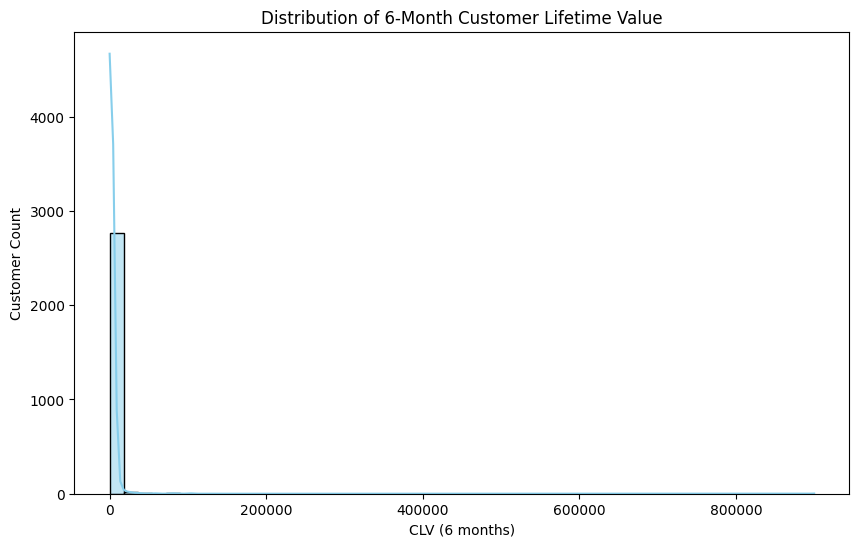

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(summary['clv_6m'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of 6-Month Customer Lifetime Value')
plt.xlabel('CLV (6 months)')
plt.ylabel('Customer Count')
plt.show()

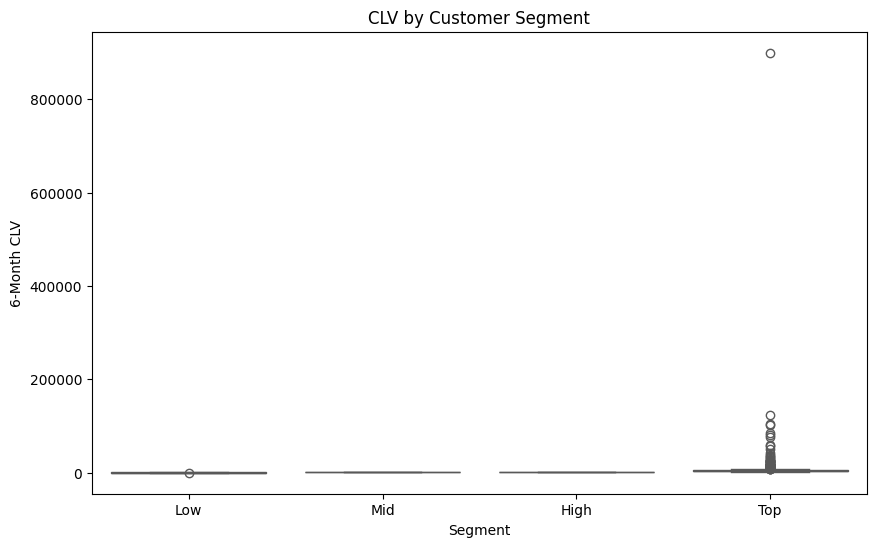

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='segment', y='clv_6m', data=summary, palette='Set2')
plt.title('CLV by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('6-Month CLV')
plt.show()

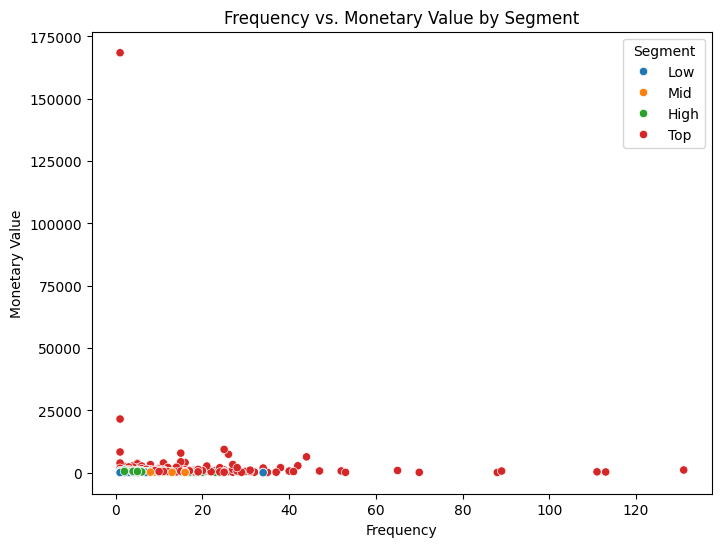

In [44]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=summary, x='frequency', y='monetary_value', hue='segment', palette='tab10')
plt.title('Frequency vs. Monetary Value by Segment')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.legend(title='Segment')
plt.show()

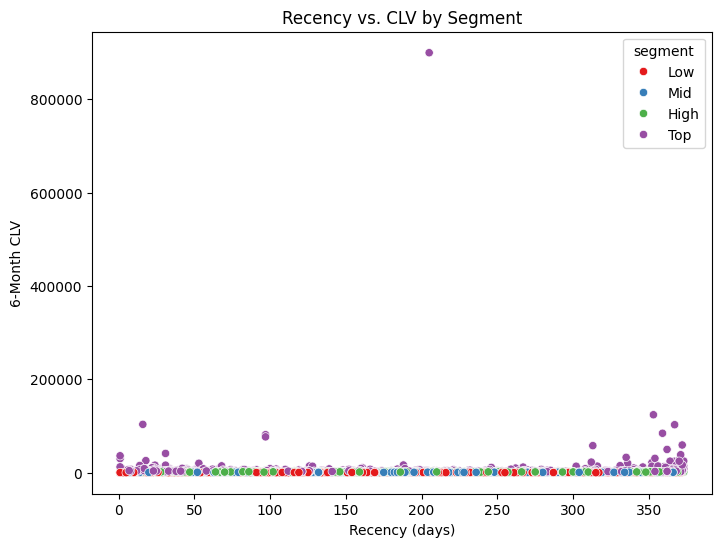

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=summary, x='recency', y='clv_6m', hue='segment', palette='Set1')
plt.title('Recency vs. CLV by Segment')
plt.xlabel('Recency (days)')
plt.ylabel('6-Month CLV')
plt.show()

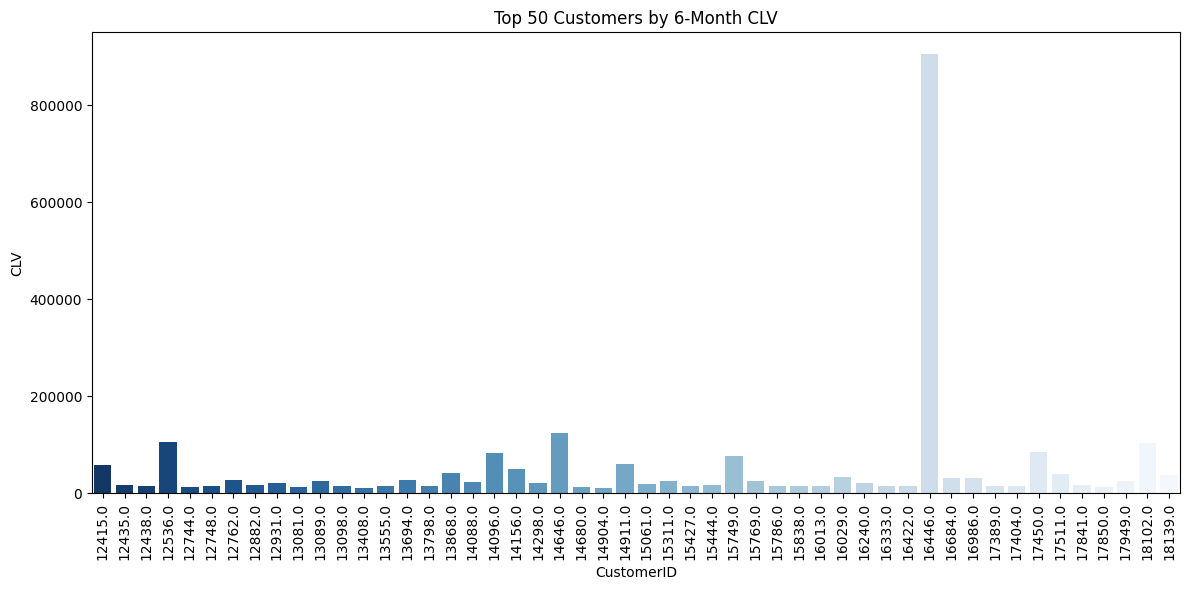

In [57]:
top_customers = summary.sort_values(by='clv_6m', ascending=False).head(50)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_customers, x='CustomerID', y='clv_6m', palette='Blues_r')
plt.title('Top 50 Customers by 6-Month CLV')
plt.xticks(rotation=90)
plt.ylabel('CLV')
plt.tight_layout()
plt.show()

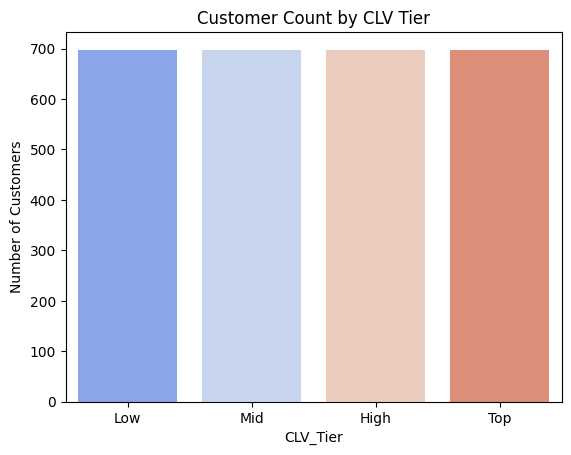

In [59]:
summary['CLV_Tier'] = pd.qcut(summary['clv_6m'], q=4, labels=['Low', 'Mid', 'High', 'Top'])
sns.countplot(data=summary, x='CLV_Tier', order=['Low', 'Mid', 'High', 'Top'], palette='coolwarm')
plt.title('Customer Count by CLV Tier')
plt.ylabel('Number of Customers')
plt.show()

In [60]:
summary.to_csv('customer_summary_for_tableau.csv', index=False)
print("Data exported successfully!")

Data exported successfully!
